# Answering questions before starting
- Increasing the number of sample drawn from the variational posterior : I will not write a modification of the number to empirically check the effect as it consumes computing time and makes the notebook les readable, so I will answer theoretically by statistical reasonning. Increasing the number of draws will make the parameters more accurate by law of large number, therefore mean of each parameter is going to converge to its true value, as well as standard deviation, making lower and upper bounds more narrowed.
- Above 2 standard deviations we observe no anomalies anymore
- It is unlikely to have predicted covid impact using only this modelling. However COVID was not the first pandemic humanity suffered, the swine flu example is pretty similar to covid (to less extent). So we could have trained the model with a Dummy variable (year of pandemic 1 / year without pandemic 0) to model the covid effect. 

In [1]:
%matplotlib inline
import matplotlib as mpl
#from matplotlib import pylab as plot
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import collections

import pandas as pd
import numpy as np
#import tensorflow.compat.v2 as tf
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

#tf.enable_v2_behavior()

In [58]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

# Import H1 data

In [84]:
raw_data = pd.read_csv('C:/Users/amaur/Documents/Data_science/Bayesian_TS/british_airways.csv')
raw_data.head()

,Date,Adjusted Passenger Count
0,2005-07-01,21686
1,2005-08-01,20084
2,2005-09-01,20635
3,2005-10-01,18988
4,2005-11-01,15554


In [85]:
raw_data.dtypes

Date                        object
Adjusted Passenger Count     int64
dtype: object

In [86]:
raw_data.rename(columns={'Adjusted Passenger Count':'passengers_count'}, inplace=True)

In [103]:
raw_data['Date'] = pd.to_datetime(raw_data['Date'])

# Calculate min and max date
min_date = raw_data['Date'].min()
max_date = raw_data['Date'].max()

# Generate weekly interval using pandas date_range
monthly_dates = pd.date_range(start=min_date, end=max_date, freq='MS')

# Convert the pandas DatetimeIndex to a numpy.ndarray with datetime64 type
passenger_dates = monthly_dates.to_numpy(dtype=np.datetime64)
passenger_dates = passenger_dates.astype('datetime64[M]')

## date printing formater 
passenger_loc = mdates.MonthLocator(interval=12)
passenger_fmt = mdates.DateFormatter('%Y-%m')

## Number of forcasting steps (half a year)
num_forecast_steps = 12

## Formating time serie data
serial_data = raw_data.passengers_count.tolist()
serial_data = np.array(serial_data).astype(np.float32)
## Training_data
training_data = serial_data[:-num_forecast_steps]

In [104]:
raw_data.dtypes

Date                datetime64[ns]
passengers_count             int64
dtype: object

---
# Defining plot functions

In [ ]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [ ]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

In [ ]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
  """Plot a time series against a model's one-step predictions."""

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  fig=plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1,1,1)
  num_timesteps = one_step_mean.shape[-1]
  ax.plot(dates, observed_time_series, label="observed time series", color=c1)
  ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
  ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()
  fig.tight_layout()
  return fig, ax

# Plotting data

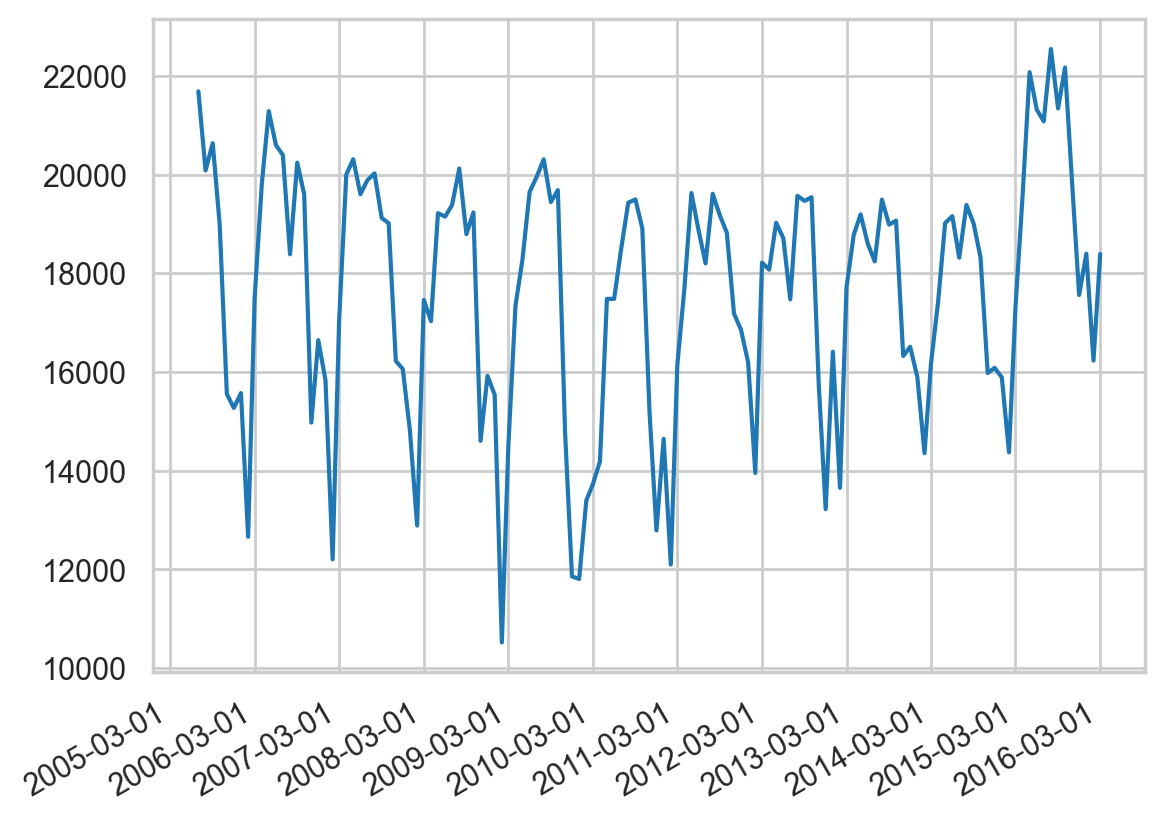

In [105]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.plot(raw_data.Date, raw_data.passengers_count)
plt.gcf().autofmt_xdate()
plt.show()

Ok so from a basic plotting and at first sight :
- the process seems stationnary although a small trend is not to exclude
- It is clear how seasonnality is defined, low daeson around march, high season around june, so 2 seasons with duration 6 month

---

## Time serie decomposition : Be more robust than simple visual analysis
- Objective : have a first idea on which type of component we will include in the STS framework (is there a trend that we did not see ? Is there a seasonnality and to which frequency)
- Method_1 : We could check if the data are stationnary - exclude trend if data are and check at an ACF to see pick of correlation for seasonnality (say we are interested at infra year seasonnality as theory in hostel business pushes us toward thinking of quarterly cancelation scheme a bit before summer and a bit before christmas - if data come from northern hemisphere christian countries). Method 1 is scientifically robust but less visual and easy to interpret
- Method_2 : Use the deasonal decomposition function from statsmodel which makes it easy to visualy interpret

Let us use method_2


<Figure size 1000x800 with 0 Axes>

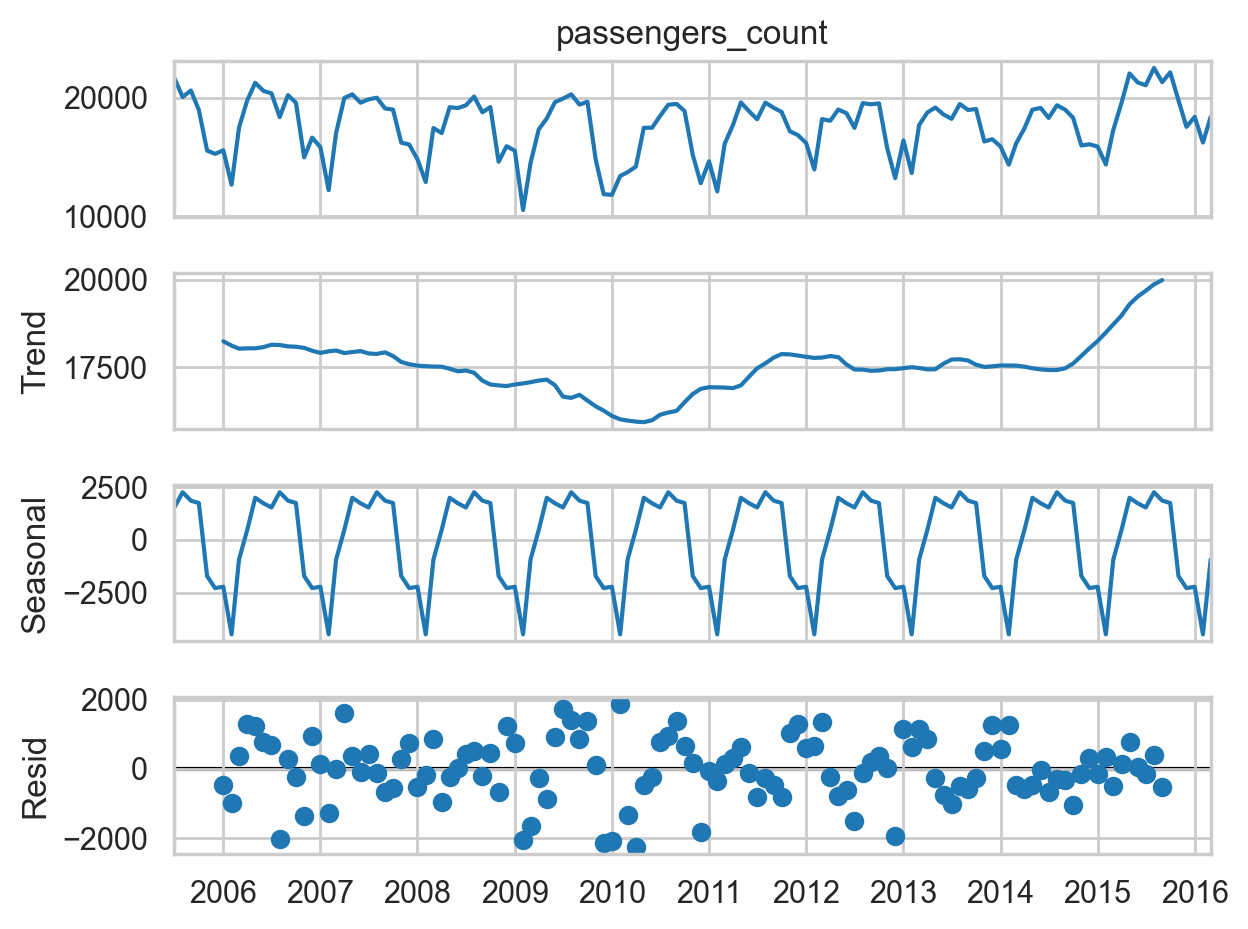

In [106]:
indexed_raw_data = raw_data.set_index('Date')
indexed_raw_data.index.freq = 'MS'
decomposition = seasonal_decompose(indexed_raw_data['passengers_count'], model='additive')
plt.figure(figsize=(10, 8))
decomposition.plot()
plt.show()

What we conclude for component to include in our structural time serie modelling
- We should not include local trend
- We should include a seasonnality (indeed quarterly)

## Now let us check if there is a specific structure of ARMA type in order to monitor variance that could be explosive in such a model

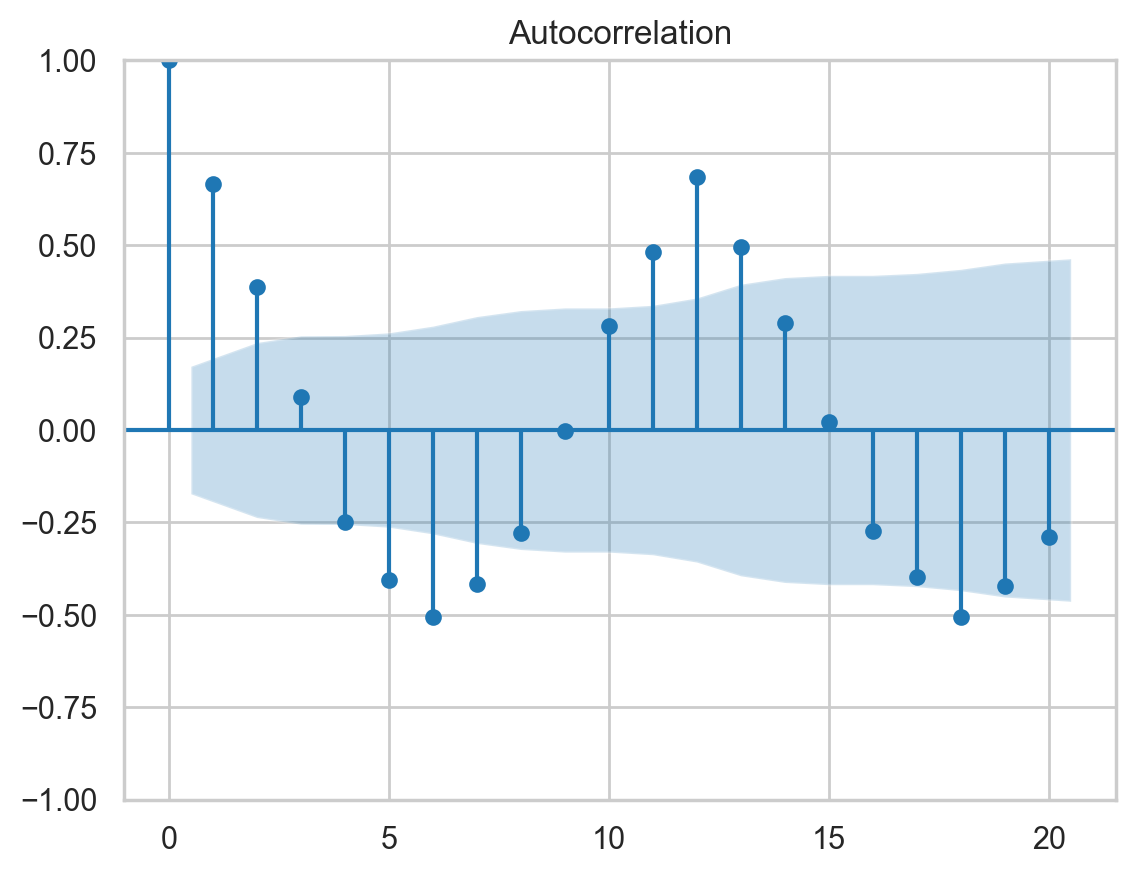

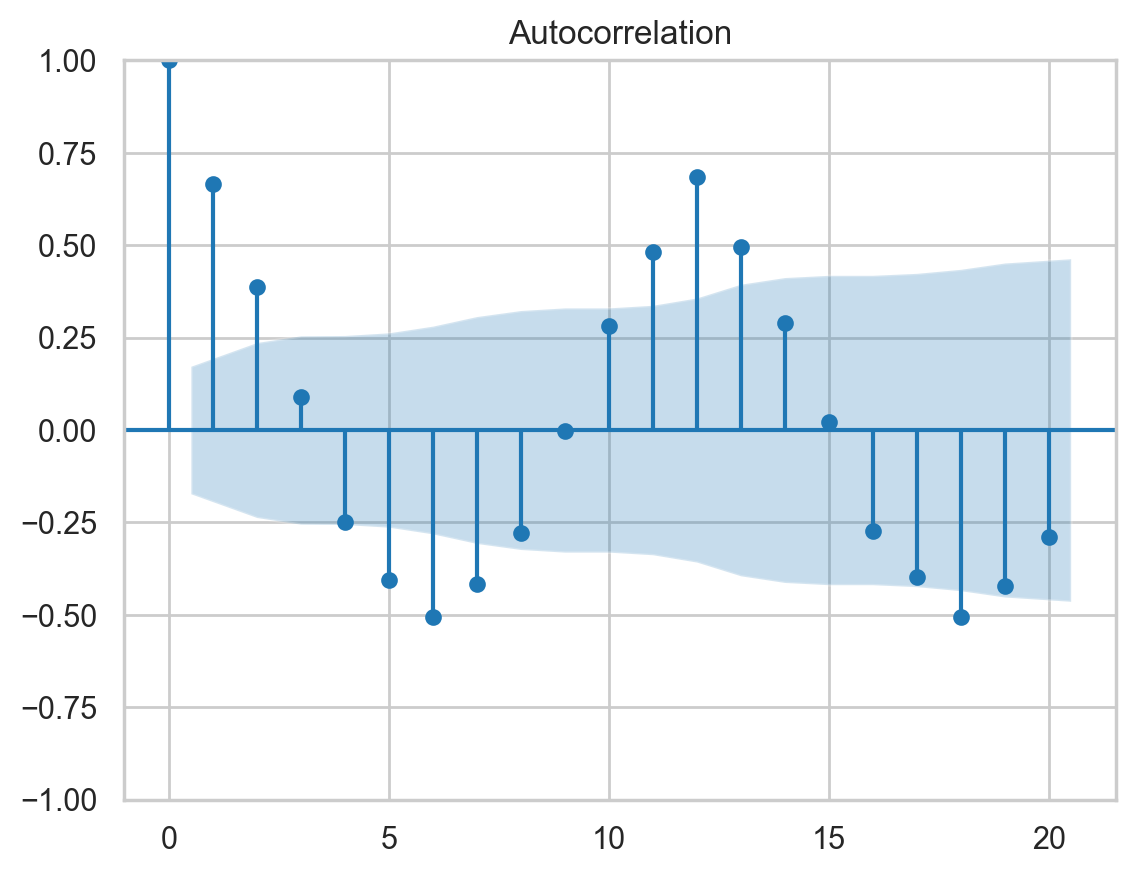

In [107]:
acf,confidence_interval=sm.tsa.acf(serial_data, nlags=20 ,alpha=0.05, fft=False)
plot_acf(serial_data, lags=20)

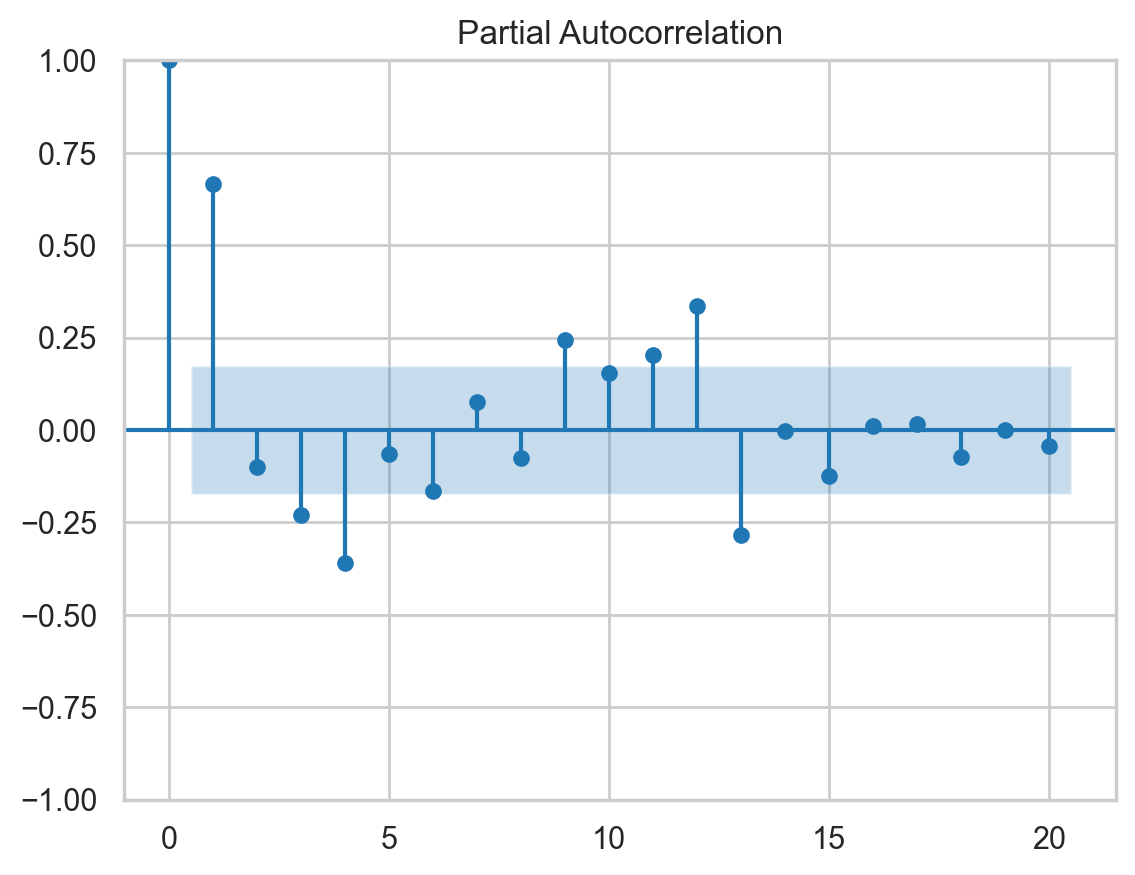

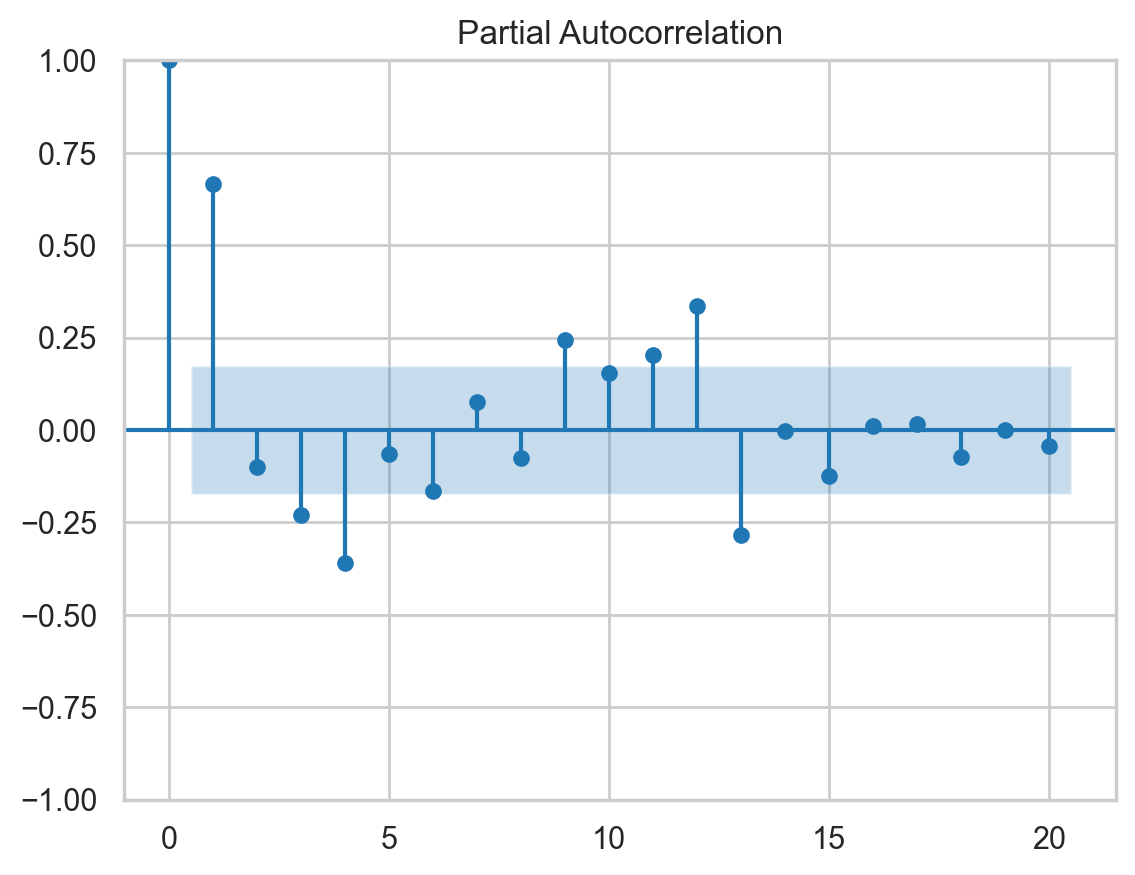

In [108]:
pacf,confidence_interval=sm.tsa.pacf(serial_data, nlags=20 ,alpha=0.05)
plot_pacf(serial_data, lags=20)

Given the ACF and PACF plots we can reasonnably bet on a ARMA(1,2) process that we want to integrate in the STS we create

---

# Structural Time Serie Modelling : Create model and optimize

In [149]:
def build_model(observed_time_series, ar, ma):
  #trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal_semester = tfp.sts.Seasonal(num_seasons=12, num_steps_per_season = 1, observed_time_series=observed_time_series,
  name = 'semester variation')
  arma = tfp.sts.AutoregressiveIntegratedMovingAverage(ar_order=ar, ma_order=ma, observed_time_series=observed_time_series)
  model = sts.Sum([seasonal_semester, arma], observed_time_series=observed_time_series)
  return model

In [150]:
passenger_model = build_model(training_data, 12, 12)
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=passenger_model)

In [151]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 400 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

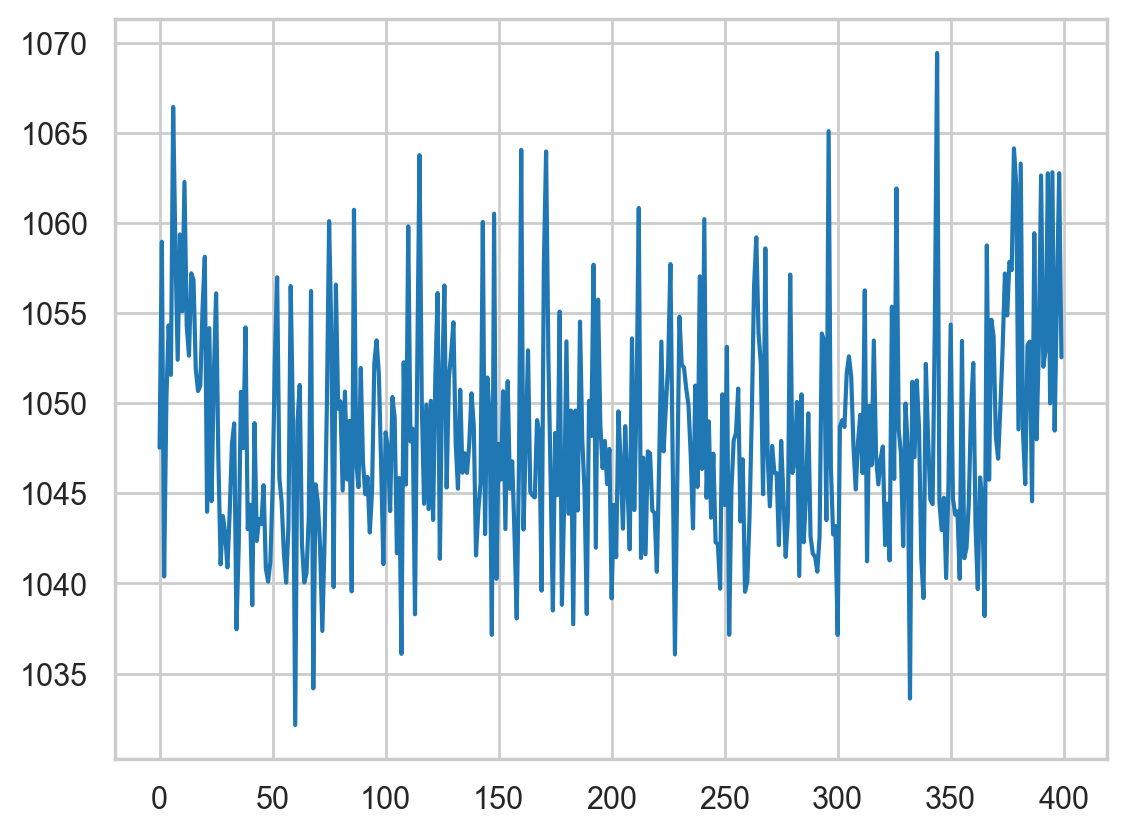

In [166]:
# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=passenger_model.joint_distribution(observed_time_series=training_data).log_prob,
    surrogate_posterior=variational_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True)

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_passenger_ = variational_posteriors.sample(1000)

---
# Doing forecasting

In [171]:
passenger_forecast_dist = tfp.sts.forecast(
    passenger_model,
    observed_time_series=training_data,
    parameter_samples=q_samples_passenger_,
    num_steps_forecast=num_forecast_steps)

# Number of scenarii (draws from posterior distribution)
num_samples=100

passenger_forecast_mean, passenger_forecast_scale, passenger_forecast_samples = (
    passenger_forecast_dist.mean().numpy()[..., 0],
    passenger_forecast_dist.stddev().numpy()[..., 0],
    passenger_forecast_dist.sample(num_samples).numpy()[..., 0])

--
### plotting

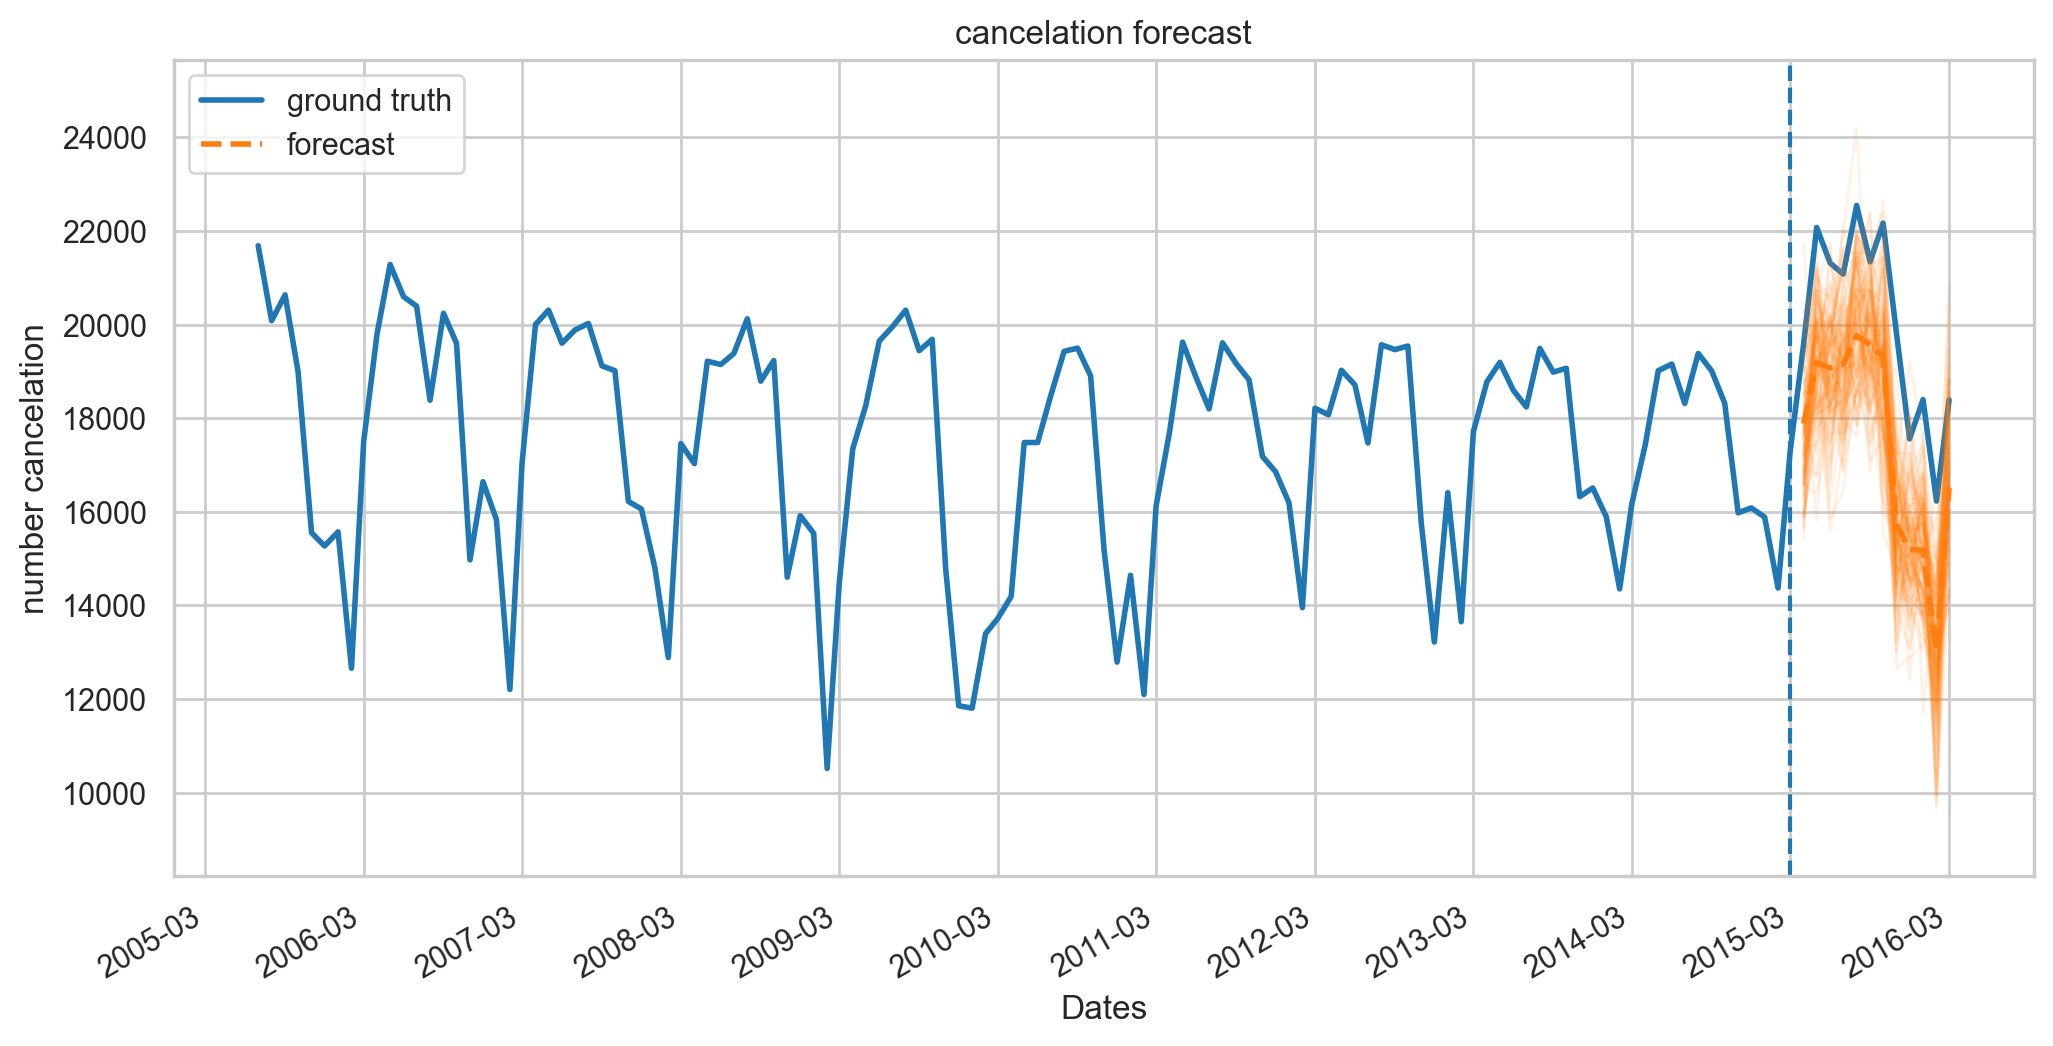

In [172]:
fig, ax = plot_forecast(
    passenger_dates, serial_data,
    passenger_forecast_mean, passenger_forecast_scale, passenger_forecast_samples,
    x_locator=cancelation_loc,
    x_formatter=cancelation_fmt,
    title="cancelation forecast")
ax.axvline(cancelation_dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("number cancelation")
ax.set_xlabel("Dates")
fig.autofmt_xdate()

In [173]:
### Mapping model components
component_dists = sts.decompose_by_component(
    passenger_model,
    observed_time_series=training_data,
    parameter_samples=q_samples_passenger_)

forecast_component_dists = sts.decompose_forecast_by_component(
    passenger_model,
    forecast_dist=passenger_forecast_dist,
    parameter_samples=q_samples_passenger_)

In [174]:
passenger_component_means_, passenger_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

(
    passenger_forecast_component_means_,
    passenger_forecast_component_stddevs_
) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )

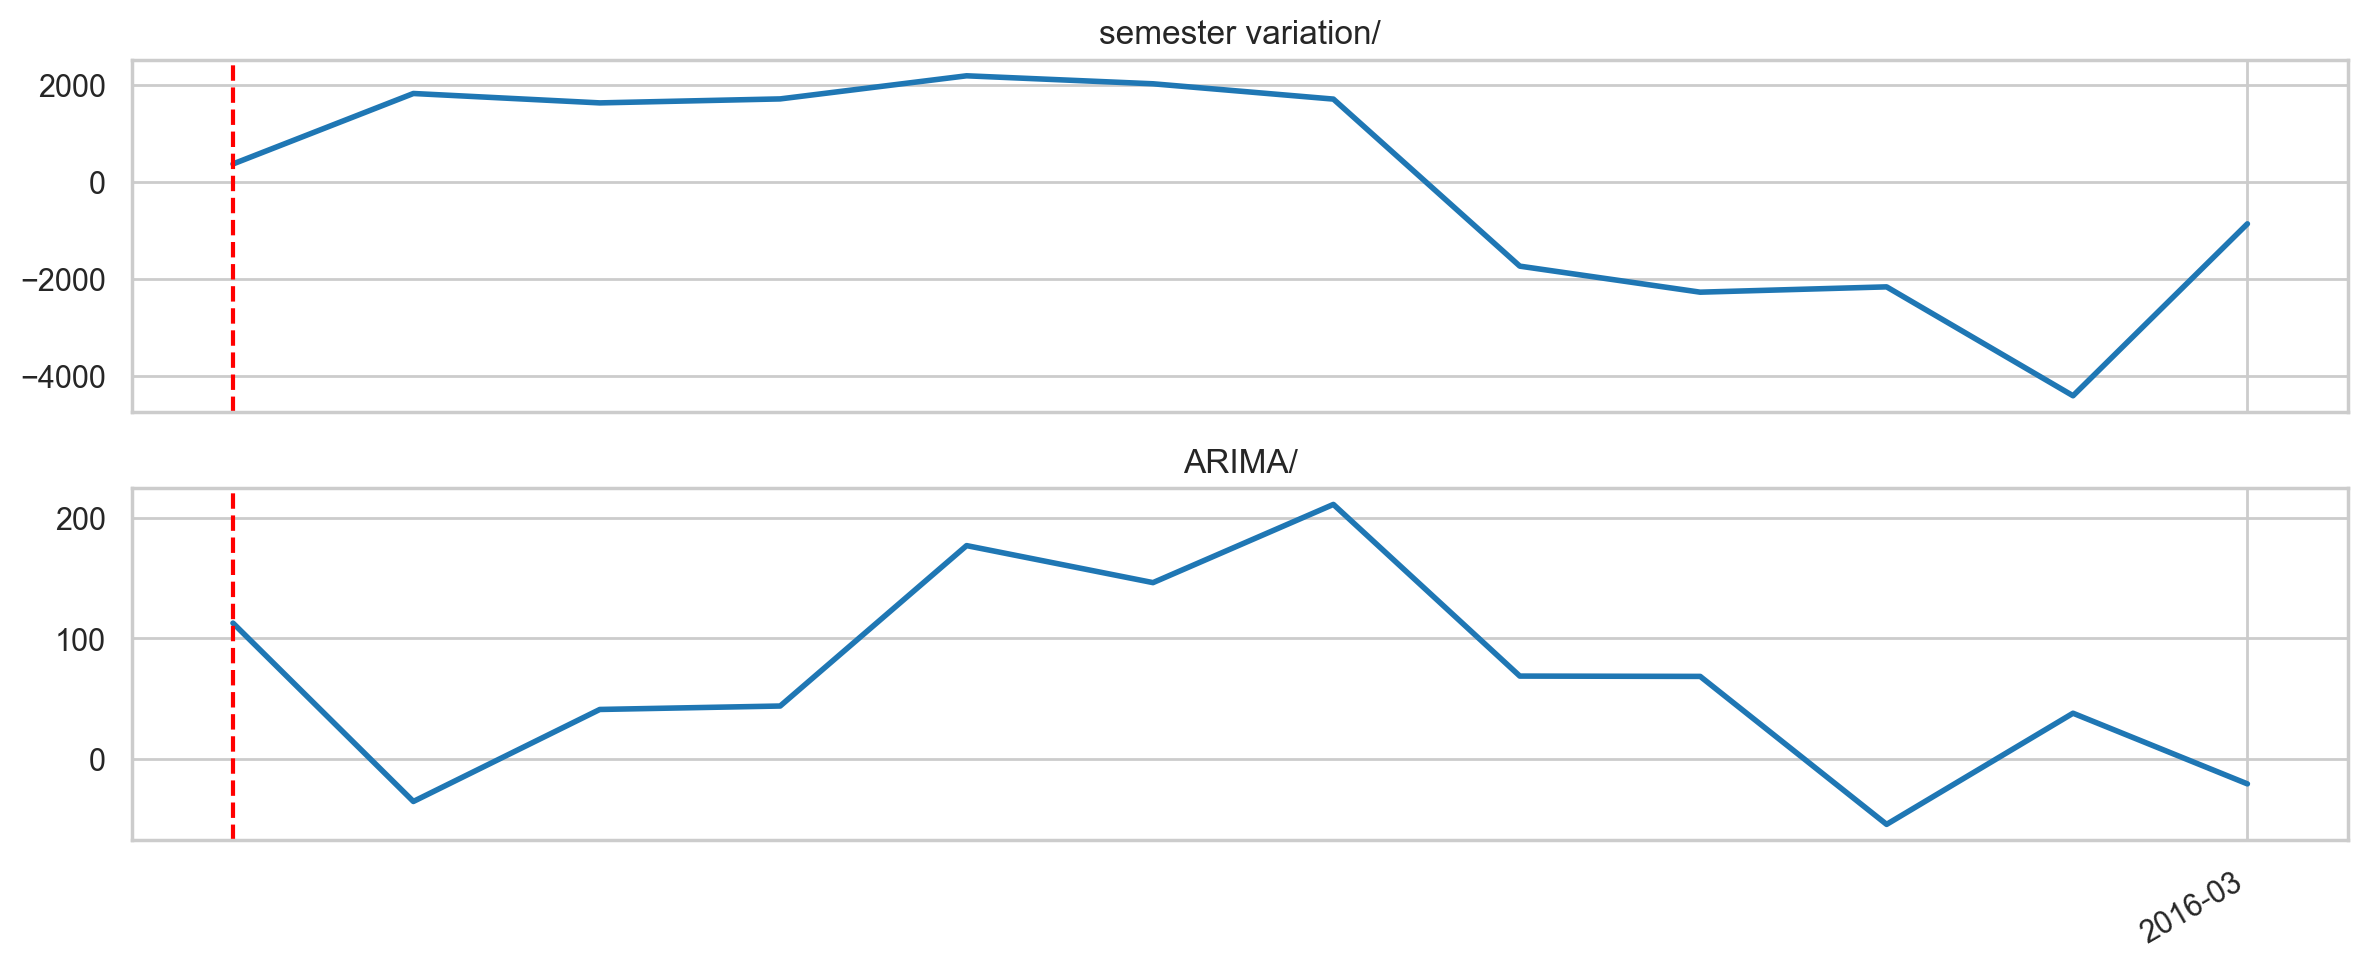

In [175]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in passenger_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      passenger_component_means_[k],
      passenger_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      passenger_component_stddevs_[k],
      passenger_forecast_component_stddevs_[k]], axis=-1)


fig, axes = plot_components(
  passenger_dates,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=passenger_loc, x_formatter=passenger_fmt)
for ax in axes.values():
  ax.axvline(passenger_dates[-num_forecast_steps], linestyle="--", color='red')

# One step prediction

In [177]:
passenger_one_step_dist = sts.one_step_predictive(
    passenger_model,
    observed_time_series=serial_data,
    parameter_samples=q_samples_passenger_,
    timesteps_are_event_shape=False)

passenger_one_step_mean, passenger_one_step_scale = (
    passenger_one_step_dist.mean().numpy(), passenger_one_step_dist.stddev().numpy())

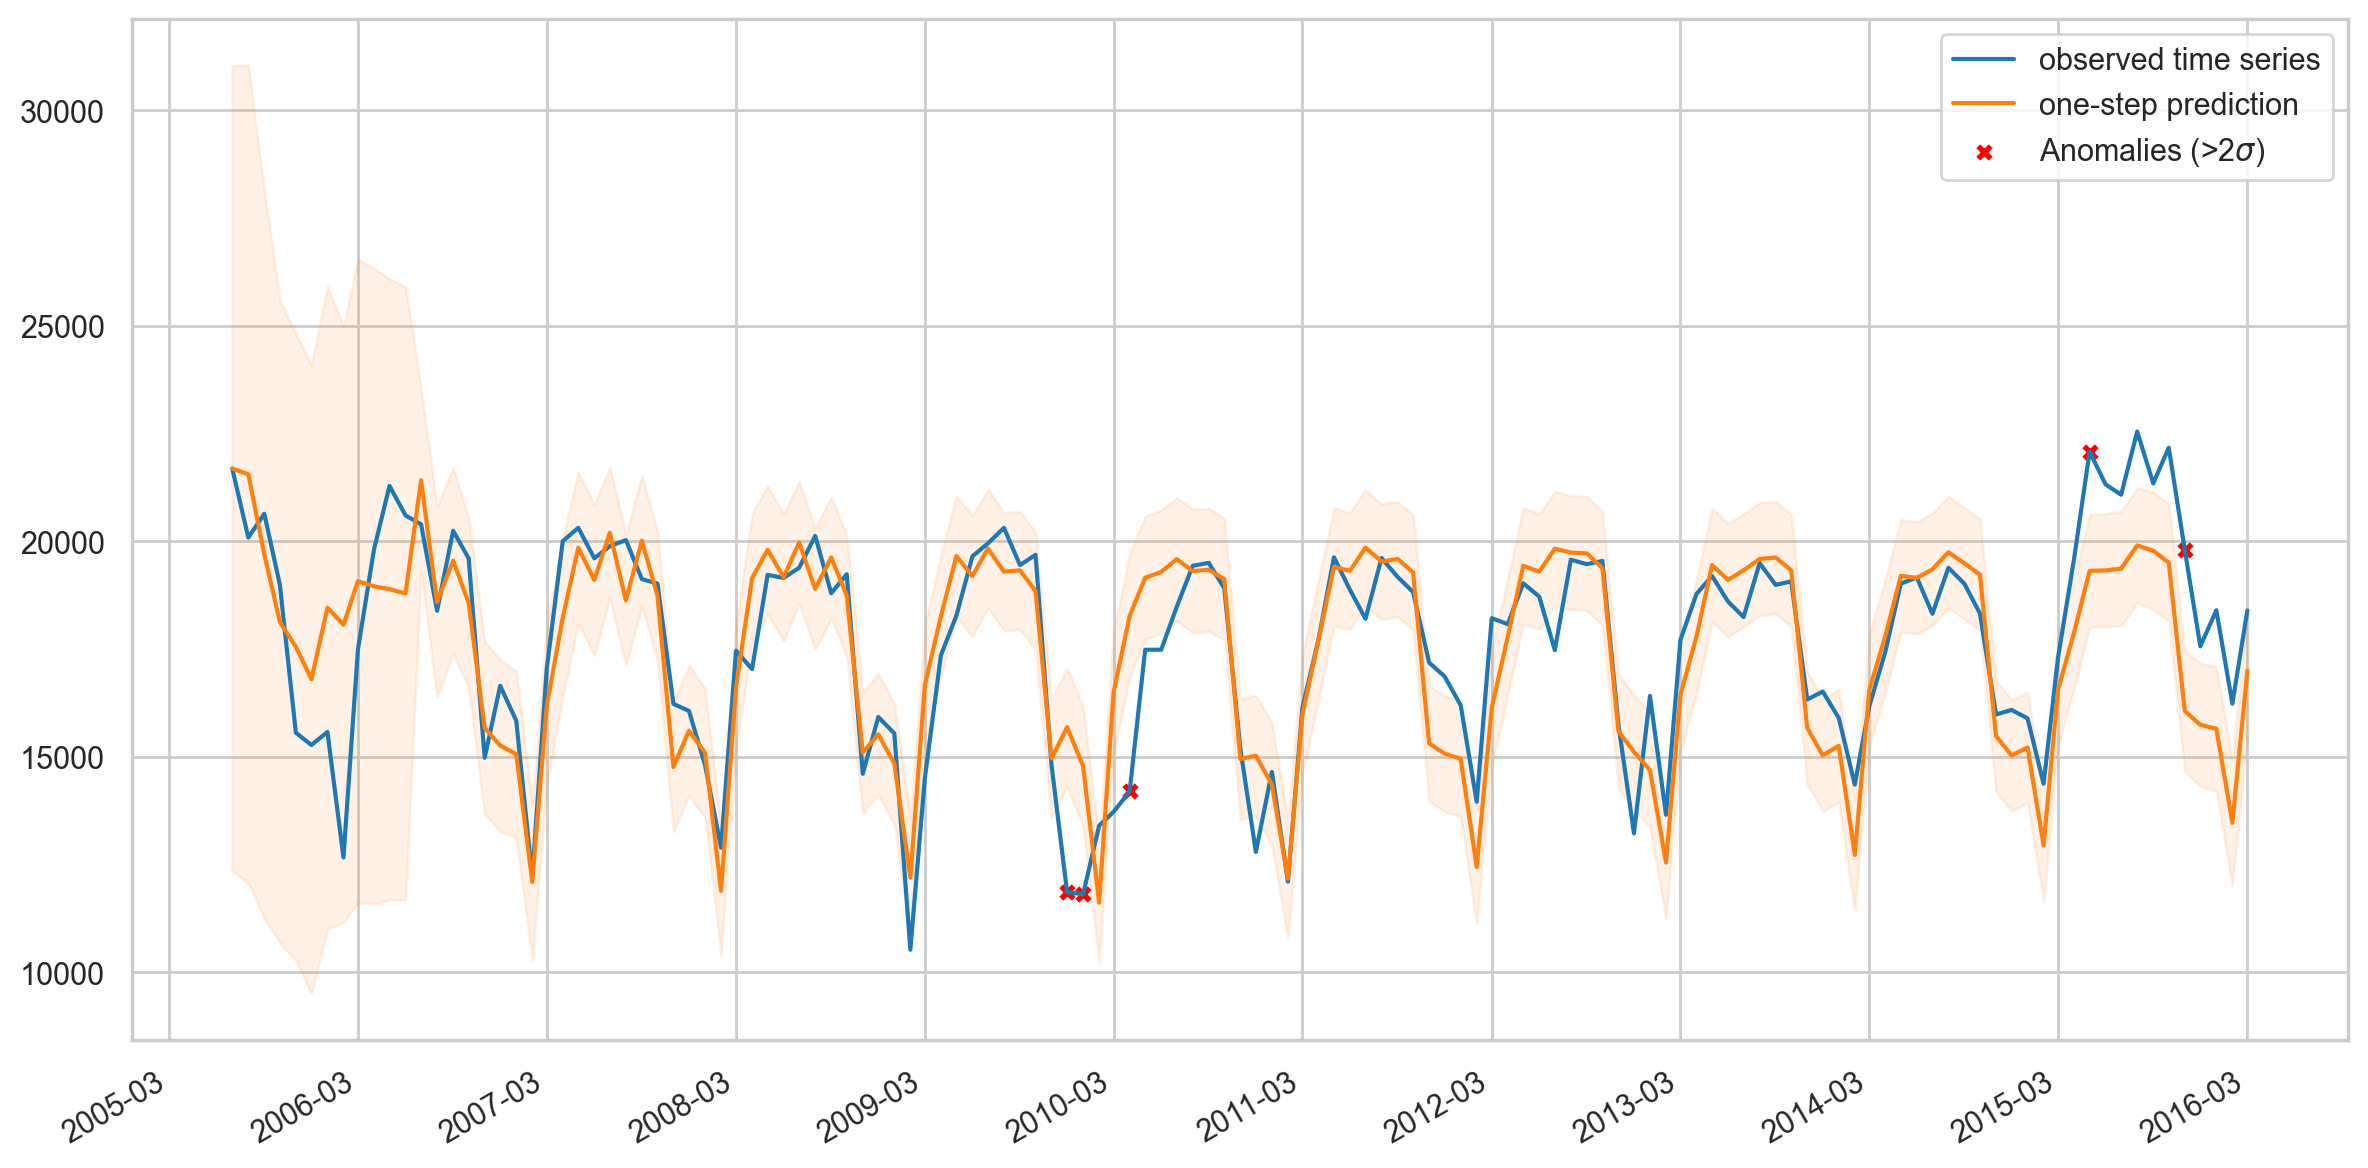

In [183]:
fig, ax = plot_one_step_predictive(
    passenger_dates, serial_data,
    passenger_one_step_mean, passenger_one_step_scale,
    x_locator=passenger_loc, x_formatter=passenger_fmt)
#ax.set_ylim(0, 10)

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((serial_data - passenger_one_step_mean) /
                 passenger_one_step_scale)
anomalies = zscores > 2.0
ax.scatter(passenger_dates[anomalies],
           serial_data[anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>2$\sigma$)")
#ax.plot(passenger_dates, zscores, color="black", alpha=0.1, label='predictive z-score')
ax.legend()
plt.show()

---